In [1]:
%load_ext autoreload
%autoreload 2

from src.models import DataLoadingSettings
from src.dataset import find_session_info, make_session_dataset
from src.processing import process_sites
from aind_behavior_vr_foraging import task_logic as vrf_task

from itertools import groupby
import logging

logger = logging.getLogger(__name__)

In [2]:
settings = DataLoadingSettings()
session_info = list(find_session_info(settings))

groupby_subject = groupby(session_info, key=lambda x: x.subject)
for subject, sessions in groupby_subject:
    print(f"Subject: {subject}")
    for session in sessions:
        print(f"  - {session.session_id} ({session.date.strftime('%Y-%m-%d')})")

session_datasets = [
    make_session_dataset(info, processing_settings=settings.processing_settings)
    for info in session_info
]
dataset = session_datasets[0]

Subject path does not exist: C:\Users\bruno.cruz\Desktop\808619
Deserialized versioned field 0.6.0-rc4, expected 0.6.0-rc8. Will attempt to coerce. This will be considered a best-effort operation.
Deserialized versioned field 0.6.0-rc4, expected 0.6.0-rc8. Will attempt to coerce. This will be considered a best-effort operation.
Deserialized versioned field 0.6.0-rc4, expected 0.6.0-rc8. Will attempt to coerce. This will be considered a best-effort operation.


Subject: 808728
  - 808728_2025-10-10T161409Z (2025-10-10)


Multiple water deliveries in interval 1975578.19168 - 1975587.17968
Multiple water deliveries in interval 1975626.641664 - 1975633.249664
Multiple water deliveries in interval 1976610.55568 - 1976668.93968


In [3]:
_colormap = [
    "#1b9e77",
    "#d95f02",
    "#7570b3",
    "#e7298a",
    "#66a61e",
    "#e6ab02",
    "#a6761d",
]


def get_color_from_site(site_label: str, patch_idx: int) -> str:
    if site_label == vrf_task.VirtualSiteLabels.REWARDSITE:
        base_color = _colormap[patch_idx % len(_colormap)]
    elif site_label == vrf_task.VirtualSiteLabels.INTERPATCH:
        base_color = "#A9A9A9"
    elif site_label == vrf_task.VirtualSiteLabels.INTERSITE:
        base_color = "#4C4C4C"
    else:
        raise ValueError(f"Unknown site label: {site_label}")
    return base_color

In [4]:
sites = process_sites(dataset.dataset)

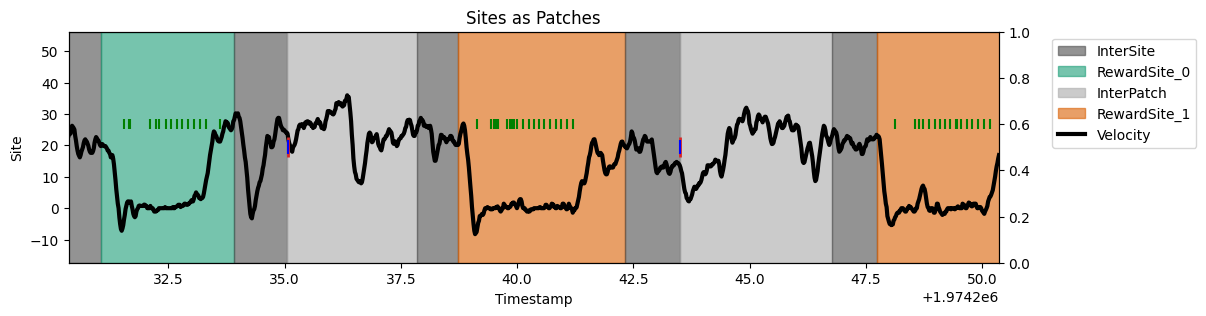

In [7]:
center_timestamp = sites["t_start"].iloc[0] + 30
window_size = 20
from matplotlib import pyplot as plt
import numpy as np

window_start = center_timestamp - window_size / 2
window_end = center_timestamp + window_size / 2

fig, ax = plt.subplots(figsize=(12, 3))

mask = (sites["t_end"] >= window_start) & (sites["t_start"] <= window_end)
for i, row in sites[mask].iterrows():
    color = get_color_from_site(row["site_label"], row["patch_idx"])
    ax.axvspan(
        row["t_start"], row["t_end"], color=color, alpha=0.6, label=row["plot_label"]
    )
ax.plot(
    dataset.processed_streams.position_velocity["velocity"],
    color="k",
    label="Velocity",
    lw=3,
)

trials = dataset.trials
ax2 = ax.twinx()
ax2.set_ylim(0, 1)
ax2.scatter(
    trials["choice_time"].index,
    np.ones_like(trials["choice_time"]) * 0.5,
    color="C3",
    label="Choices",
    marker="|",
    s=200,
    lw=2,
)
ax2.scatter(
    trials["reward_time"].index,
    np.ones_like(trials["reward_time"]) * 0.5,
    color="blue",
    label="Rewards",
    marker="|",
    s=100,
)
ax2.scatter(
    dataset.processed_streams.lick_onsets,
    np.ones_like(dataset.processed_streams.lick_onsets) * 0.6,
    color="green",
    label="Licks",
    marker="|",
    s=50,
)
ax.set_xlabel("Timestamp")
ax.set_ylabel("Site")
ax.set_title("Sites as Patches")
ax.set_xlim(window_start, window_end)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(
    by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc="upper left"
)
plt.show()

In [6]:
trials = dataset.trials
trials

,choice_time,reward_time,reaction_duration,patch_index,is_rewarded,p_reward
odor_onset_time,,,,,,
1.974218e+06,1.974214e+06,1.974215e+06,-3.573024,1,True,1.0
1.974225e+06,1.974222e+06,1.974223e+06,-3.233984,0,True,1.0
1.974235e+06,1.974232e+06,1.974232e+06,-3.497984,0,True,1.0
1.974244e+06,1.974240e+06,1.974240e+06,-3.973984,1,True,1.0
1.974252e+06,1.974248e+06,1.974249e+06,-3.873984,1,True,1.0
...,...,...,...,...,...,...
1.977718e+06,NaN,NaN,NaN,1,False,1.0
1.977725e+06,NaN,NaN,NaN,1,False,1.0
1.977730e+06,1.977728e+06,1.977728e+06,-2.039008,0,True,1.0


## Metrics to grab:
* Total distance traveled
* Number of sites
* Number of rewards
* P(Stop | Odor)

## Plots
* Histogram of inter-odor distances and time
* Odor aligned velocity
